In [3]:
!pip install opendatasets xgboost==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.2
    Uninstalling xgboost-3.1.2:
      Successfully uninstalled xgboost-3.1.2


In [4]:
import opendatasets as od
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

# Configuring plotting style
plt.style.use('ggplot')

In [5]:
# Downloading dataset from kaggle (originally at UCL Machine Learning Repository)
dataset_url = 'https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahsanatiq98
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset


100%|██████████| 4.60G/4.60G [01:08<00:00, 71.8MB/s]


In [6]:
import opendatasets as od
import pandas as pd
import numpy as np
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import os


# Loading mat file
data_path = './BloodPressureDataset/part_1.mat' # Using only 1 mat file for testing
mat_data = scipy.io.loadmat(data_path)['p']
mat_df = pd.DataFrame(mat_data)
mat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,"[[1.7595307917888563, 1.718475073313783, 1.684...","[[2.409579667644184, 2.329423264907136, 2.2385...","[[1.2121212121212122, 1.2013685239491692, 1.19...","[[2.442815249266862, 2.345063538611926, 2.2424...","[[1.1681329423264908, 1.2043010752688172, 1.26...","[[1.5425219941348973, 1.5239491691104594, 1.50...","[[1.5483870967741935, 1.5239491691104594, 1.49...","[[1.7331378299120235, 1.6705767350928642, 1.60...","[[1.2121212121212122, 1.1964809384164223, 1.18...","[[2.6901270772238512, 2.6617790811339197, 2.62...",...,"[[1.4271749755620724, 1.4037145650048877, 1.38...","[[1.6608015640273706, 1.6285434995112416, 1.59...","[[2.6314760508308894, 2.5425219941348973, 2.45...","[[1.2658846529814272, 1.2434017595307918, 1.22...","[[1.5855327468230693, 1.6177908113391983, 1.67...","[[2.164222873900293, 2.09188660801564, 2.02932...","[[0.9990224828934506, 1.0009775171065494, 1.00...","[[1.2316715542521994, 1.2678396871945259, 1.33...","[[1.2541544477028348, 1.2453567937438905, 1.23...","[[1.5913978494623655, 1.7350928641251222, 1.90..."


Understanding the data:

1.   Data contains a single list of 1000 patients
2.   Each patients contains 3 rows
3.   Each patient have almost 5 minutes of recording (written in data card)





In [7]:
# Extracting signals (rows) from the file
ppg_list, abp_list, ecg_list = [], [], []

# Total recordings are approx.
# 5 * 60 = 300 seconds
# 300 * 125 = 37,700 frames

# selecting windows of 5 sec from 300 seconds
sample_size = 625
print("Processing signals...")
for i in range(mat_data.shape[1]): # Exploring each nested array
    patient_data = mat_data[0, i] # Getting the array of each patient
    total_samples = patient_data.shape[1] # Getting total samples
    num_windows = total_samples // sample_size # Cuttting down by 5 sec

    for j in range(num_windows):
        start = j * sample_size
        end = (j + 1) * sample_size
        ppg_list.append(patient_data[0, start:end])
        abp_list.append(patient_data[1, start:end])
        ecg_list.append(patient_data[2, start:end])

# Convert to arrays for easy handelling
ppg = np.array(ppg_list)
abp = np.array(abp_list)
ecg = np.array(ecg_list)

# Converting into 3D array
X = np.stack((ppg, ecg), axis=-1)  # (N(rows), 625(cols), 2(channels))
y = abp.reshape(abp.shape[0], abp.shape[1], 1) # (N(rows), 625(cols), 1(channels))

print(f"Total Samples: {X.shape[0]}")

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


# Decision Tree and Linera regression works on 2D data therefore converting
X_train_final = X_train.reshape(X_train.shape[0], -1) # Shape: (rows, cols * channels)
X_test_final  = X_test.reshape(X_test.shape[0], -1) # Shape: (rows, cols * channels)

# Same configerations
y_train_final = y_train.reshape(y_train.shape[0], -1)
y_test_final  = y_test.reshape(y_test.shape[0], -1)

print("-" * 30)
print(f"✅ Data Recovered Successfully!")
print(f"Training Data Shape: {X_train_final.shape}")
print(f"Target Data Shape:   {y_train_final.shape} (Full 625 points)")
print("-" * 30)

Processing signals...
Total Samples: 50877
------------------------------
✅ Data Recovered Successfully!
Training Data Shape: (40701, 1250)
Target Data Shape:   (40701, 625) (Full 625 points)
------------------------------


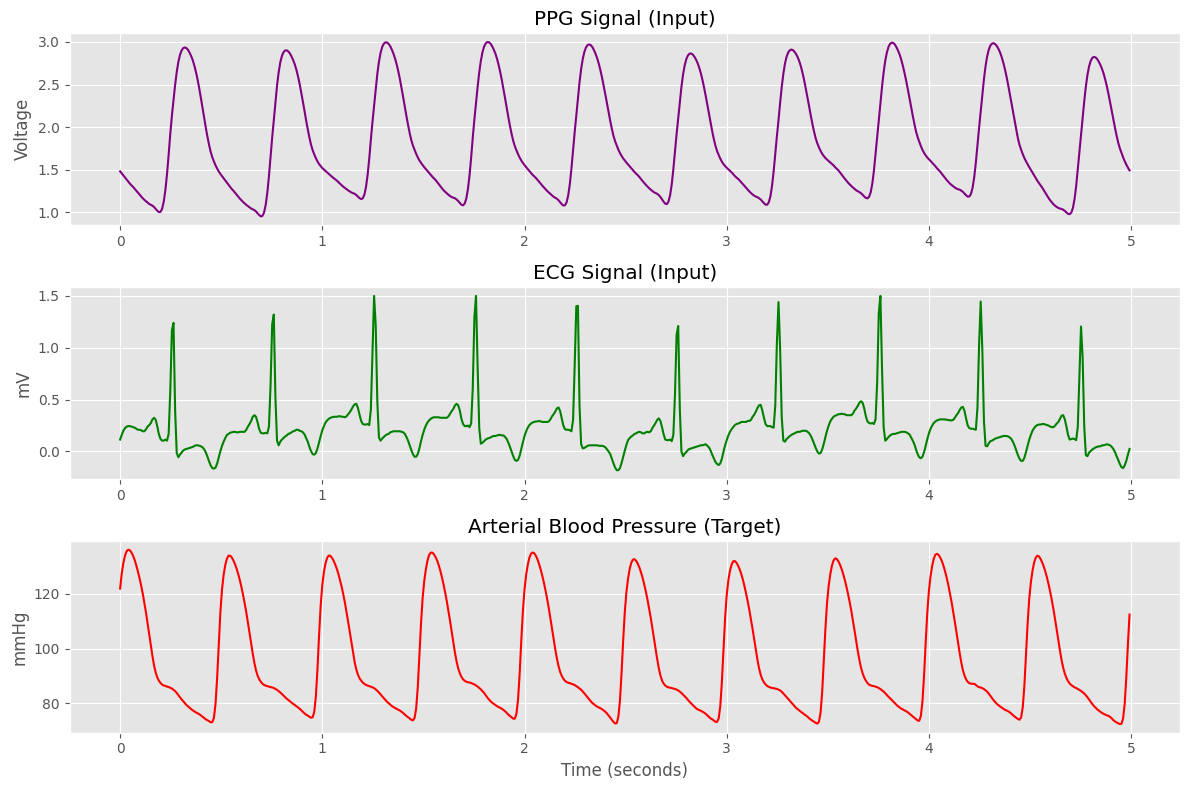

In [8]:
idx = 67 # Change this to see different windows (rows)
time_axis = np.arange(0, 5, 1/125) # 5 seconds time axis

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_axis, ppg[idx], color='purple')
plt.title("PPG Signal (Input)")
plt.ylabel("Voltage")

plt.subplot(3, 1, 2)
plt.plot(time_axis, ecg[idx], color='green')
plt.title("ECG Signal (Input)")
plt.ylabel("mV")

plt.subplot(3, 1, 3)
plt.plot(time_axis, abp[idx], color='red')
plt.title("Arterial Blood Pressure (Target)")
plt.ylabel("mmHg")
plt.xlabel("Time (seconds)")

plt.tight_layout()
plt.show()

/tmp/ipython-input-3664307258.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


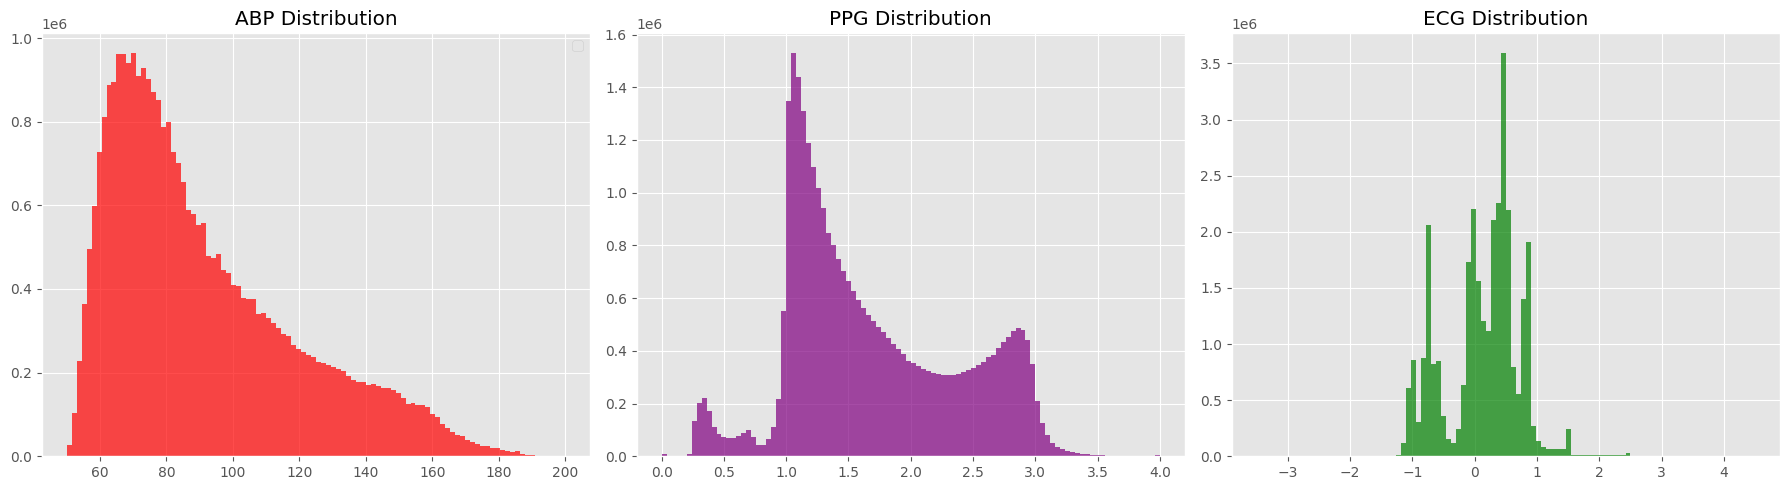

In [9]:
plt.figure(figsize=(18, 5))

# ABP (Target)
plt.subplot(1, 3, 1)
plt.hist(abp.flatten(), bins=100, color='red', alpha=0.7)
plt.title("ABP Distribution")
plt.legend()

# PPG
plt.subplot(1, 3, 2)
plt.hist(ppg.flatten(), bins=100, color='purple', alpha=0.7)
plt.title("PPG Distribution")

# ECG
plt.subplot(1, 3, 3)
plt.hist(ecg.flatten(), bins=100, color='green', alpha=0.7)
plt.title("ECG Distribution")

plt.tight_layout()
plt.show()

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# Training Decision Trees
dt_full = DecisionTreeRegressor(
    max_depth=15,          # Increased Depth
    max_features='sqrt',   # RAM limitations
    random_state=42
)

start = time.time()
dt_full.fit(X_train_final, y_train_final)
end = time.time()

print(f" Decision Tree Trained in {end - start:.2f} seconds!")

# Evaluate
dt_preds_full = dt_full.predict(X_test_final)
mae_dt = mean_absolute_error(y_test_final, dt_preds_full)
print(f"Decision Tree Full MAE: {mae_dt:.2f} mmHg")

 Decision Tree Trained in 39.82 seconds!
Decision Tree Full MAE: 14.50 mmHg


📊 Generating Decision Tree Graph comparing Ground Truth...


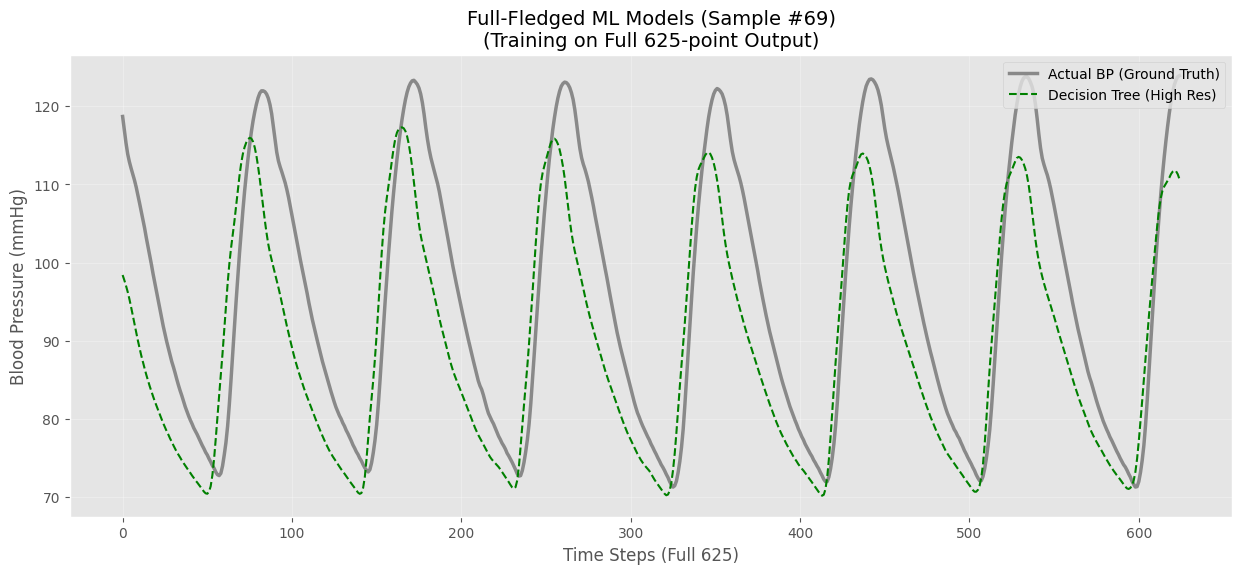

In [11]:
import matplotlib.pyplot as plt
import numpy as np

print("📊 Generating Decision Tree Graph comparing Ground Truth...")


sample_idx = 69 # change sample to visualize diffrent window

full_truth = y_test_final[sample_idx] # Ground Trut hwaveform

dt_prediction = dt_preds_full[sample_idx]

# Plotting Graph
plt.figure(figsize=(15, 6))

# Layer 1: Ground Truth (Black Line)
plt.plot(full_truth, label='Actual BP (Ground Truth)', color='black', linewidth=2.5, alpha=0.4)

# Layer 2: Decision Tree Prediction (Green Dashed)
plt.plot(dt_prediction, label=f'Decision Tree (High Res)', color='green', linestyle='--', linewidth=1.5)

# Styling
plt.title(f"Full-Fledged ML Models (Sample #{sample_idx})\n(Training on Full 625-point Output)", fontsize=14)
plt.xlabel("Time Steps (Full 625)")
plt.ylabel("Blood Pressure (mmHg)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

 Training Linear Regression 
 Linear Regression Trained in 26.46 seconds!
Linear Regression Full MAE: 13.11 mmHg


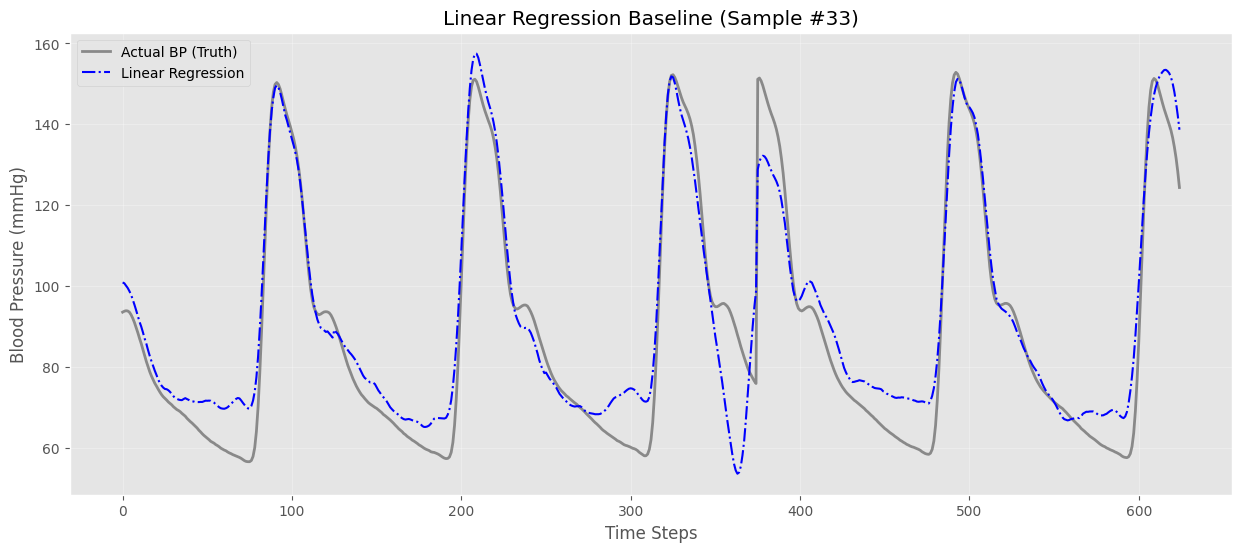

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import time
import matplotlib.pyplot as plt
import numpy as np

print(" Training Linear Regression ")

# n_jobs=-1 means use all cores
lr_model = LinearRegression(n_jobs=-1)

# --- 2. Training ---
start = time.time()
lr_model.fit(X_train_final, y_train_final)
end = time.time()

print(f" Linear Regression Trained in {end - start:.2f} seconds!")

# Evaluating Model
lr_preds = lr_model.predict(X_test_final)
mae_lr = mean_absolute_error(y_test_final, lr_preds)

print(f"Linear Regression Full MAE: {mae_lr:.2f} mmHg")

# Plotting Graph: Predicted vs Ground Truth Waveform
sample_idx = 33 # Same sample for comparison

plt.figure(figsize=(15, 6))

# Ground Truth
plt.plot(y_test_final[sample_idx], label='Actual BP (Truth)', color='black', alpha=0.4, linewidth=2)

# Linear Regression Prediction
plt.plot(lr_preds[sample_idx], label='Linear Regression', color='blue', linestyle='-.')

plt.title(f"Linear Regression Baseline (Sample #{sample_idx})")
plt.xlabel("Time Steps")
plt.ylabel("Blood Pressure (mmHg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization, Bidirectional, MaxPooling1D, UpSampling1D

print("🐉 Building the 'Dragon' (King-Size) Model...")

input_shape = (625, 2)

model = Sequential([
    # --- BLOCK 1: High-Res Feature Extraction (CNN) ---
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.2),

    # --- BLOCK 2: Deep Temporal Understanding (Bi-LSTM) ---
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    # --- BLOCK 3: Refinement ---
    LSTM(64, return_sequences=True),

    # --- Output ---
    TimeDistributed(Dense(128, activation='relu')), # Dense layer barha di
    TimeDistributed(Dense(1, activation='linear'))
])

optimizer = Adam(learning_rate=0.001) # Learning rate same rakhein
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

🐉 Building the 'Dragon' (King-Size) Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 625, 128)       │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 625, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 625, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 625, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 625, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 625, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 625, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 625, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 625, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 625, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 625, 64)        │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 625, 128)       │         8,320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 625, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,561 (3.18 MB)

 Trainable params: 833,025 (3.18 MB)

 Non-trainable params: 1,536 (6.00 KB)

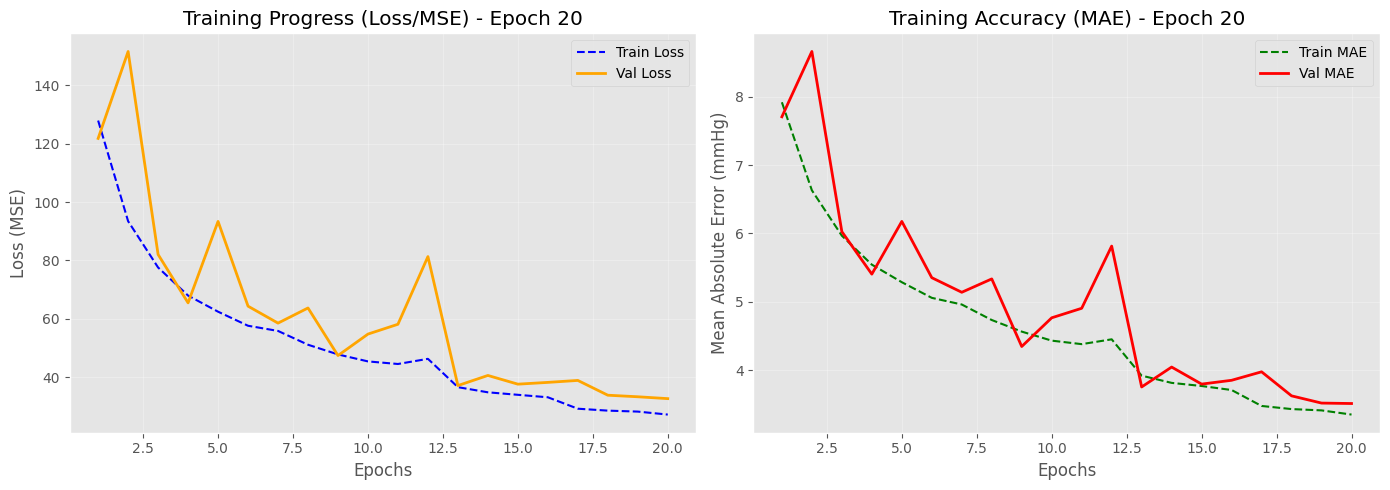

📈 Graph updated at Epoch 20. Continuing training...
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 401s 315ms/step - loss: 27.0630 - mae: 3.3434 - val_loss: 32.7003 - val_mae: 3.5097 - learning_rate: 2.5000e-04
Epoch 21/30
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 383s 301ms/step - loss: 26.8382 - mae: 3.3251 - val_loss: 32.3733 - val_mae: 3.5024 - learning_rate: 2.5000e-04
Epoch 22/30
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 385s 303ms/step - loss: 25.7516 - mae: 3.2702 - val_loss: 34.8625 - val_mae: 3.7879 - learning_rate: 2.5000e-04
Epoch 23/30
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 381s 299ms/step - loss: 25.7523 - mae: 3.2551 - val_loss: 33.1122 - val_mae: 3.5357 - learning_rate: 2.5000e-04
Epoch 24/30
 144/1272 ━━━━━━━━━━━━━━━━━━━━ 5:17 281ms/step - loss: 24.0649 - mae: 3.2086

KeyboardInterrupt: 

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# --- 1. Define the Custom Callback Class ---
class FiveEpochMonitor(tf.keras.callbacks.Callback):
    """
    This is the custom cal back funtion:
    1. Saves the model in each 5 epochs
    2. Updates the graph every 5 epochs
    """
    def __init__(self, model_name_prefix="dragon_checkpoint"):
        super().__init__()
        self.prefix = model_name_prefix
        # History to store list
        self.epoch_count = []
        self.history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

    def on_epoch_end(self, epoch, logs=None):
        # Storing logs after each epoch
        logs = logs or {}
        self.epoch_count.append(epoch + 1)
        for k, v in logs.items():
            self.history[k].append(v)

        # Checking
        if (epoch + 1) % 5 == 0:
            # --- Task A: Save Model ---
            save_path = f"{self.prefix}_epoch_{epoch+1}.keras"
            self.model.save(save_path)
            print(f"\n Milestone reached! Model saved as: {save_path}")

            # --- Task B: Plot Dynamic Graph ---
            self._plot_progress()

    def _plot_progress(self):
        # Removing old output
        clear_output(wait=True)

        epochs = self.epoch_count

        plt.figure(figsize=(14, 5))

        # Subplot 1: LOSS (MSE)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['loss'], label='Train Loss', color='blue', linestyle='--')
        plt.plot(epochs, self.history['val_loss'], label='Val Loss', color='orange', linewidth=2)
        plt.title(f"Training Progress (Loss/MSE) - Epoch {epochs[-1]}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (MSE)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Subplot 2: MAE (Error in mmHg)
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['mae'], label='Train MAE', color='green', linestyle='--')
        plt.plot(epochs, self.history['val_mae'], label='Val MAE', color='red', linewidth=2)
        plt.title(f"Training Accuracy (MAE) - Epoch {epochs[-1]}")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error (mmHg)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.show()
        print(f"📈 Graph updated at Epoch {epochs[-1]}. Continuing training...")


# --- 2. Instantiate Callbacks ---

print(" Initializing the '5-Epoch Monitor'...")

monitor_cb = FiveEpochMonitor(model_name_prefix="dragon_lite")

# Purane zaroori callbacks (Learning rate kam karna aur jaldi rokna)
# Note: Hum 'ModelCheckpoint' hata rahay hain kyunke hamara naya monitor ab save karega.
lr_dragon = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop_dragon = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)


# --- 3. Start Training (Batch Size 32) ---
print("🚀 Starting Training with Live Monitoring...")

# NOTE: Make sure 'model' is compiled before running this!
history_dragon = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,  # Safe batch size
    # Callbacks ki list mein naya monitor shamil karein
    callbacks=[monitor_cb, lr_dragon, early_stop_dragon],
    verbose=1 # Har epoch ki progress bar dikhaye
)

print("✅ Dragon Training Complete!")

Session Crashed due to free tier limit reached

In [14]:
# Load Best Weights
try:
    model.load_weights("best_dl_model.keras")
    print("✅ Best weights loaded.")
except:
    print("⚠️ Used current weights.")

# Predict on full test set
lstm_preds = model.predict(X_test)

# Reshape for metric calculation (N, 625) for evaluation
lstm_preds_flat = lstm_preds.reshape(lstm_preds.shape[0], -1)
y_test_flat_full = y_test.reshape(y_test.shape[0], -1)

mae_lstm = mean_absolute_error(y_test_flat_full, lstm_preds_flat)
rmse_lstm = np.sqrt(mean_squared_error(y_test_flat_full, lstm_preds_flat))

print("-" * 30)
print(f"🥇 LSTM Mean Absolute Error: {mae_lstm:.2f} mmHg")
print(f"🥇 LSTM Root Mean Squared Error: {rmse_lstm:.2f} mmHg")
print("-" * 30)

⚠️ Used current weights.
318/318 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step
------------------------------
🥇 LSTM Mean Absolute Error: 3.42 mmHg
🥇 LSTM Root Mean Squared Error: 5.59 mmHg
------------------------------


🎨 Generating Graph for YOUR Selected Sample...
✅ Prediction Complete!

🏆 OVERALL SCORE CARD:
   MAE:  3.4192 mmHg
   RMSE: 5.5871 mmHg

👉 Plotting Sample Index: 67


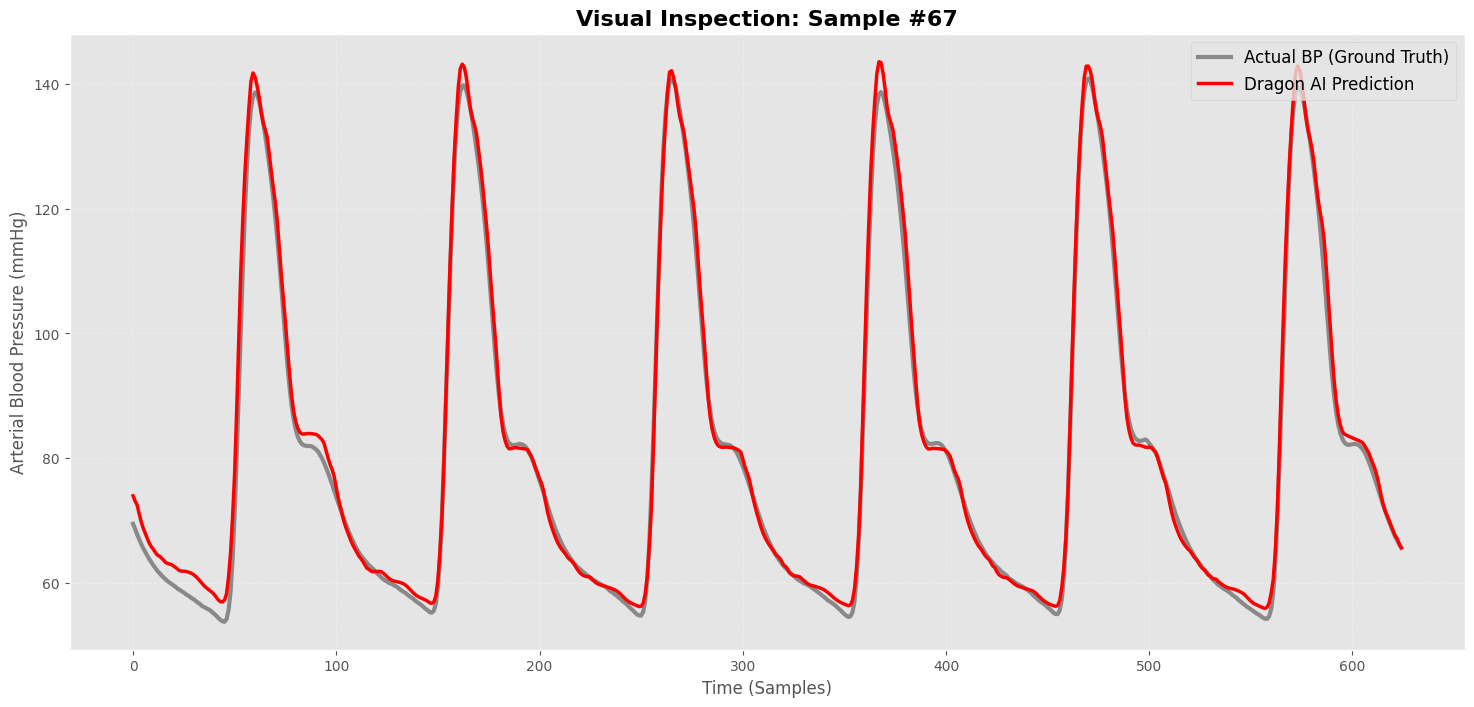

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("🎨 Generating Graph for YOUR Selected Sample...")

# --- 1. Generate Predictions (Dragon LSTM) ---
try:
    preds_dragon = model.predict(X_test, verbose=0)
    print("✅ Prediction Complete!")
except NameError:
    print("❌ Error: Model ya X_test nahi mila.")
    raise

# --- 2. Calculate Overall Score (Poore Data ka) ---
# Flattening for metrics
y_true_flat = y_test.reshape(y_test.shape[0], -1)
y_pred_flat = preds_dragon.reshape(preds_dragon.shape[0], -1)

mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

print(f"\n🏆 OVERALL SCORE CARD:")
print(f"   MAE:  {mae:.4f} mmHg")
print(f"   RMSE: {rmse:.4f} mmHg")

# --- 3. SELECT YOUR SAMPLE HERE ---
# Yahan apni marzi ka number likhein (0 se lekar ~5000 ke darmiyan)
# sample_idx = 150
sample_idx = 67 # Ya random rehne dein

print(f"\n👉 Plotting Sample Index: {sample_idx}")

# --- 4. Plotting ---
plt.figure(figsize=(18, 8))

# Layer A: Actual BP (Black)
plt.plot(y_true_flat[sample_idx], label='Actual BP (Ground Truth)', color='black', linewidth=3, alpha=0.4)

# Layer B: Dragon Model (Red)
plt.plot(y_pred_flat[sample_idx], label=f'Dragon AI Prediction', color='red', linewidth=2.5)


# Styling
plt.title(f"Visual Inspection: Sample #{sample_idx}", fontsize=16, fontweight='bold')
plt.xlabel("Time (Samples)", fontsize=12)
plt.ylabel("Arterial Blood Pressure (mmHg)", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


🏆 OVERALL SCORE CARD:
   MAE:  3.4192 mmHg
   RMSE: 5.5871 mmHg

👉 Plotting Sample Index: 45


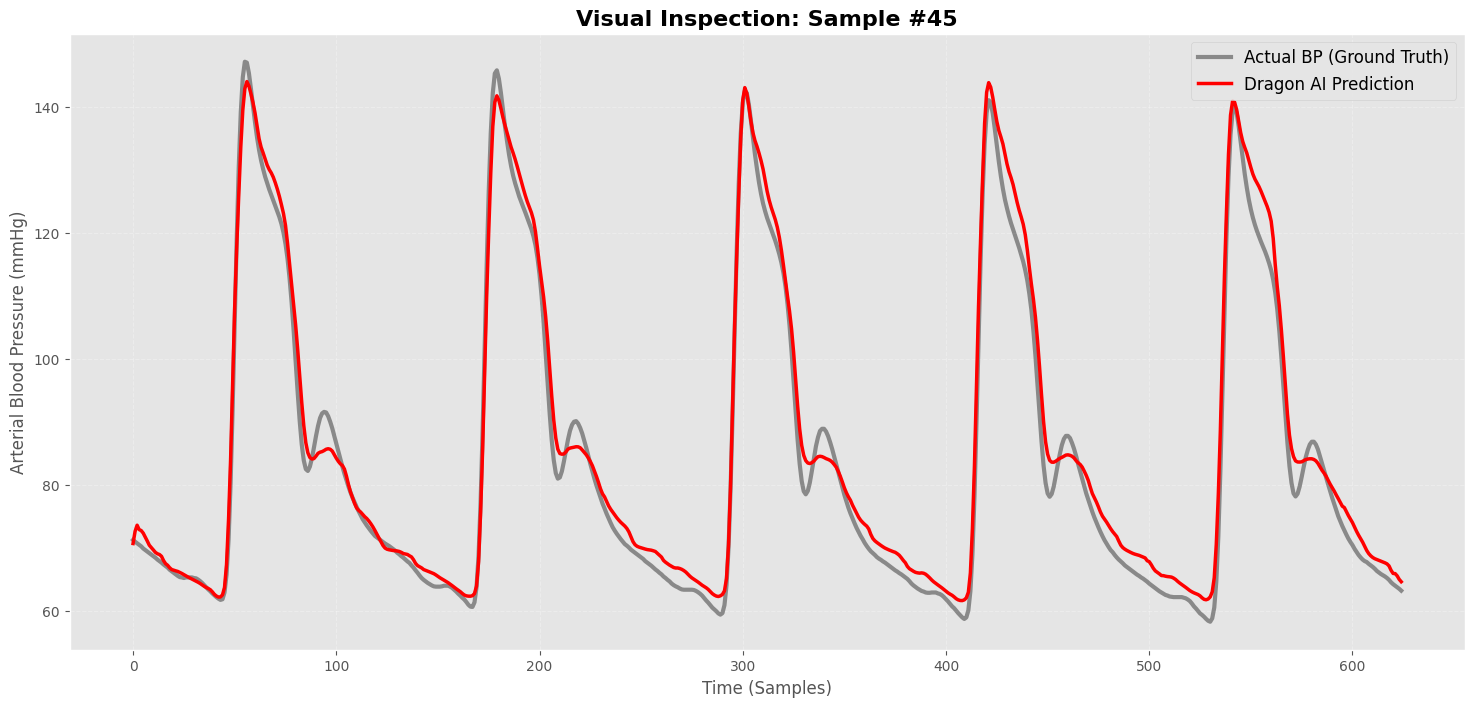

In [21]:
# --- 2. Calculate Overall Score (Poore Data ka) ---
# Flattening for metrics
y_true_flat = y_test.reshape(y_test.shape[0], -1)
y_pred_flat = preds_dragon.reshape(preds_dragon.shape[0], -1)

mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

print(f"\n🏆 OVERALL SCORE CARD:")
print(f"   MAE:  {mae:.4f} mmHg")
print(f"   RMSE: {rmse:.4f} mmHg")

# --- 3. SELECT YOUR SAMPLE HERE ---

sample_idx = 45 # any random

print(f"\n👉 Plotting Sample Index: {sample_idx}")

# --- 4. Plotting ---
plt.figure(figsize=(18, 8))

# Layer A: Actual BP (Black)
plt.plot(y_true_flat[sample_idx], label='Actual BP (Ground Truth)', color='black', linewidth=3, alpha=0.4)

# Layer B: Dragon Model (Red)
plt.plot(y_pred_flat[sample_idx], label=f'Dragon AI Prediction', color='red', linewidth=2.5)

# Layer C: Optional Baselines (Agar memory mein hain)

# Styling
plt.title(f"Visual Inspection: Sample #{sample_idx}", fontsize=16, fontweight='bold')
plt.xlabel("Time (Samples)", fontsize=12)
plt.ylabel("Arterial Blood Pressure (mmHg)", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()